In [1]:
from sympy import symbols, init_printing, Integer, zeros, Matrix, IndexedBase

import numpy as np

from fast import (State, split_hyperfine_to_magnetic, matrix_element,
                  helicity_to_cartesian, delta_greater, delta_lesser,
                  cartesian_dot_product, define_laser_variables,
                  electric_field_amplitude_intensity, polarization_vector,
                  vapour_number_density, Transition, define_density_matrix,
                  draw_multiplet)

from fast.bloch import (fast_sweep_steady_state, phase_transformation, Unfolding, radiated_intensity)
from fast.symbolic import Vector3D
from matplotlib import pyplot as plt

%matplotlib inline
init_printing()

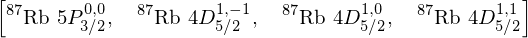

In [2]:
g = State("Rb", 87, 5, 1, 3/Integer(2), 0)
e = State("Rb", 87, 4, 2, 5/Integer(2), 1)

magnetic_states = split_hyperfine_to_magnetic([g, e])
Ne = len(magnetic_states)
magnetic_states

In [3]:
from scipy.constants import hbar, e, epsilon_0
from scipy.constants import physical_constants
a0 = physical_constants["Bohr radius"][0]
r0 = symbols("r0", positive=True)
r0 = 4.4*a0
r0

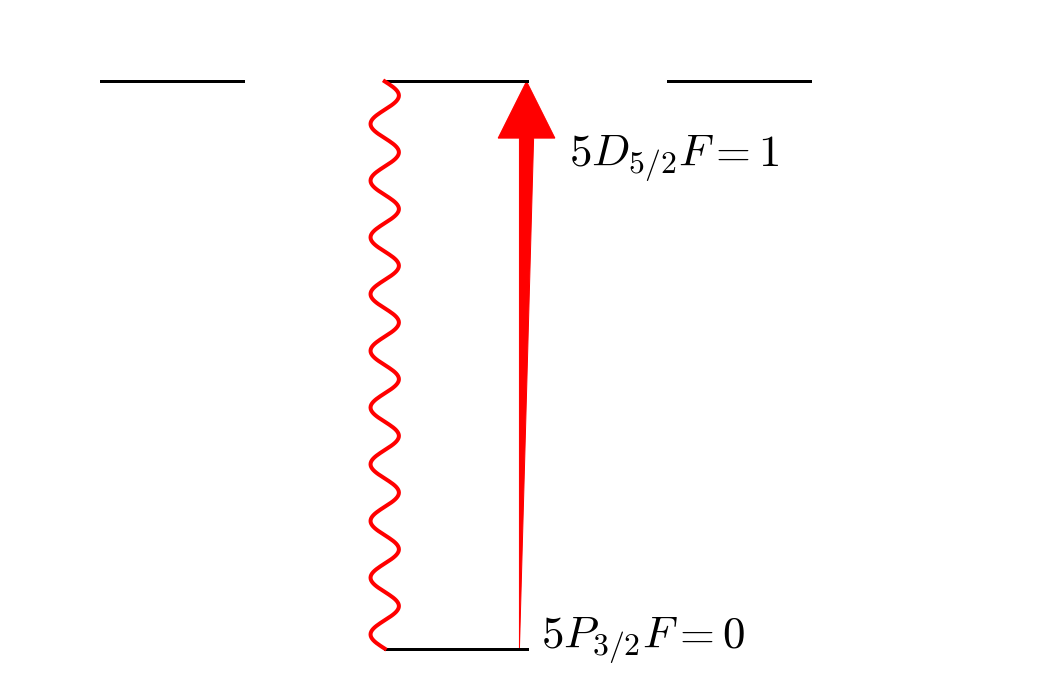

In [4]:
from fast import draw_state, excitation, decay
fig = plt.figure(figsize=(20, 12)); ax=fig.add_subplot(111,aspect="equal")

p1=[1.5,0]; p2=[1.5,2]; p3=[2.5,5]
draw_state(ax,p1,text=r"$5P_{3/2} F=0$",l=0.5,alignment='right',label_displacement=0.05,fontsize=45,linewidth=3.0)
draw_state(ax, [p2[0]-1, p2[1]],text=r"",l=0.5,alignment='right',label_displacement=0.05,fontsize=25,linewidth=3.0)
draw_state(ax, [p2[0]+0, p2[1]],text=r"",l=0.5,alignment='right',label_displacement=0.05,fontsize=25,linewidth=3.0)
draw_state(ax, [p2[0]+1, p2[1]],text="",l=0.5,alignment='right',label_displacement=0.05,fontsize=45,linewidth=3.0)

ax.text(1.9, 1.7, r"$5D_{5/2} F=1$", fontsize=45)

excitation(ax,[p1[0]+0.25,p1[1]],[p2[0]+0.25,p2[1]], fc="red", ec="red",width=0.05, head_width=0.2, head_length=0.2)
decay(     ax,[p1[0]-0.25,p1[1]],[p2[0]-0.25,p2[1]], 0.05,10.0,color="red",linewidth=4.0)

ax.set_xlim([0,3.5])
ax.set_ylim([-0.05,2.25])
plt.axis('off')
plt.savefig('_diagram.png',bbox_inches="tight")

In [5]:
II = 3/Integer(2)

r = [zeros(Ne, Ne) for i in range(3)]
for q in [-1, 0, 1]:
    for i, ei in enumerate(magnetic_states):
        ji, fi, mi = ei.quantum_numbers[-3:]
        for j, ej in enumerate(magnetic_states):
            jj, fj, mj = ej.quantum_numbers[-3:]
            
            rqij = matrix_element(ji, fi, mi, jj, fj, mj, q, II, r0, numeric=False)
            if ji == jj:
                rqij = 0
            elif ji < jj:
                rqij = matrix_element(ji, fi, mi, jj, fj, mj, q, II, r0, numeric=False)
            else:
                rqij = matrix_element(ji, fi, mi, jj, fj, mj, q, II, -r0, numeric=False)
                
            r[q+1][i,j] = rqij

r_helicity = r
r = helicity_to_cartesian(r)

rp = [np.array([[complex(r[p][i,j]*delta_lesser(i,  j)) for j in range(Ne)]for i in range(Ne)]) for p in range(3)]
rm = [np.array([[complex(r[p][i,j]*delta_greater(i, j)) for j in range(Ne)]for i in range(Ne)]) for p in range(3)]

In [6]:
Nl = 1
Ep = [electric_field_amplitude_intensity(4, units="SI", Omega=1)]
Ep_symb, _ = define_laser_variables(Nl)
epsilonp_symb = Vector3D(IndexedBase("epsilonp", shape=(Nl,)))

gamma21 = 2*np.pi*6.065e6
gamma = np.zeros((Ne, Ne))
gamma[1, 0] = gamma21
gamma[2, 0] = gamma21
gamma[3, 0] = gamma21

gamma += -gamma.transpose()

omega0 = magnetic_states[0].omega
omega_level = [ei.omega -omega0 for ei in magnetic_states]

xi = np.zeros((Nl, Ne, Ne))
xi[0, 1, 0] = 1
xi[0, 2, 0] = 1
xi[0, 3, 0] = 1
xi[0, :, :] += xi[0, :, :].transpose()

theta = phase_transformation(Ne, Nl, rm, xi)

In [7]:
sweep_steady_state = fast_sweep_steady_state(Ep_symb, epsilonp_symb, gamma, omega_level, rm, xi, theta)

In [8]:
epsilonpp = polarization_vector(0, 0, 0, np.pi/8, 1, numeric=True)
epsilonpp = np.array(epsilonpp)

epsilonpm = polarization_vector(0, 0, 0, -np.pi/8, 1, numeric=True)
epsilonpm = np.array(epsilonpm)

print epsilonpp
print epsilonpm

[ 0.70710678+0.j          0.00000000+0.70710678j  0.00000000+0.j        ]
[ 0.70710678+0.j          0.00000000-0.70710678j  0.00000000+0.j        ]


In [9]:
epsilonpx = np.array([1, 0, 0])
epsilonpy = np.array([0, 1, 0])
epsilonpz = np.array([0, 0, 1])

print epsilonpx
print epsilonpy
print epsilonpz

[1 0 0]
[0 1 0]
[0 0 1]


In [10]:
unfolding = Unfolding(Ne, True, True, True)
Mu = unfolding.Mu

In [11]:
delta0 = -2*np.pi*80e6
deltaf = +2*np.pi*80e6
Ndelta = 401

deltas, rho = sweep_steady_state(Ep, [epsilonpz], [[delta0, deltaf, Ndelta]])

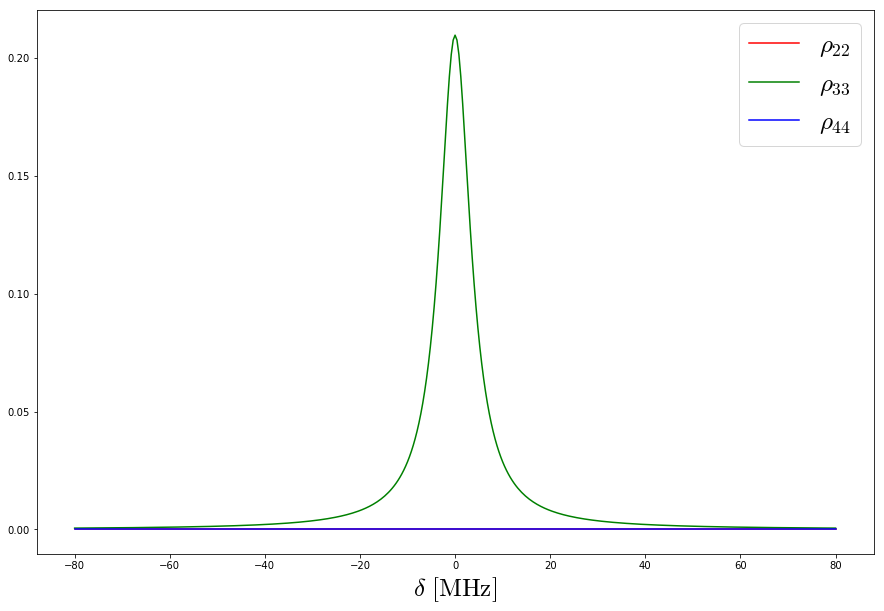

In [12]:
rho22 = rho[:, Mu(1, 1, 1)]
rho33 = rho[:, Mu(1, 2, 2)]
rho44 = rho[:, Mu(1, 3, 3)]

plt.figure(figsize=(15, 10))
plt.plot(deltas/2/np.pi*1e-6, rho22, "r-", label= r"$\rho_{22}$")
plt.plot(deltas/2/np.pi*1e-6, rho33, "g-", label= r"$\rho_{33}$")
plt.plot(deltas/2/np.pi*1e-6, rho44, "b-", label= r"$\rho_{44}$")
plt.xlabel(r"$\delta \ \mathrm{[MHz]}$", fontsize=25)
plt.legend(fontsize=25)

In [13]:
n = vapour_number_density(273.15+20, "Rb")
D = 0.001
V = 4/3.0*np.pi*(D/2)**3
N = n*V
N*1e-6

# Radiation

$$\hat{I}_\vec{\epsilon}(D) = \frac{\alpha n \hbar \omega_{ij}^4}{2\pi c^2 D^2}(\hat{\vec{r}} ^ {(-)}\cdot \vec{\epsilon}^{(+)}) (\hat{\vec{r}} ^ {(+)}\cdot \vec{\epsilon}^{(-)})$$

In [14]:
from fast.bloch import define_simplification, observable
from fast import cartesian_dot_product, PlaneWave, draw_lasers_3d
alpha_num = physical_constants["fine-structure constant"][0]
c_num = physical_constants["speed of light in vacuum"][0]

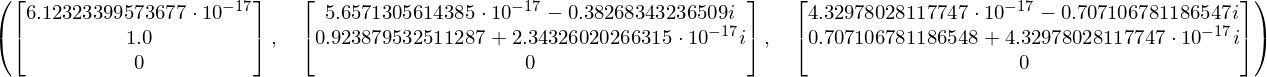

In [15]:
ll = PlaneWave(0, 0, np.pi/4, 0)
le = PlaneWave(0, 0, np.pi/4, np.pi/16)
lp = PlaneWave(0, 0, np.pi/4, np.pi/8)

epl = ll.epsilonp
epe = le.epsilonp
epp = lp.epsilonp

Matrix(epl), Matrix(epe), Matrix(epp)

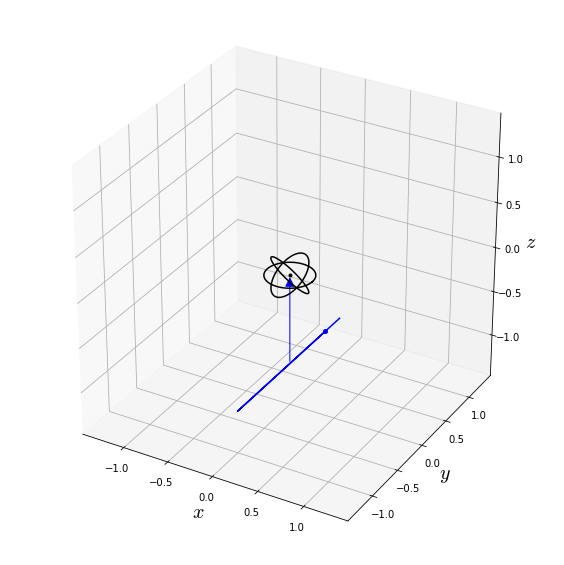

In [16]:
fig = plt.figure(figsize=(10, 10)); ax = fig.gca(projection='3d')
draw_lasers_3d(ax,[ll], '_lasers.png')

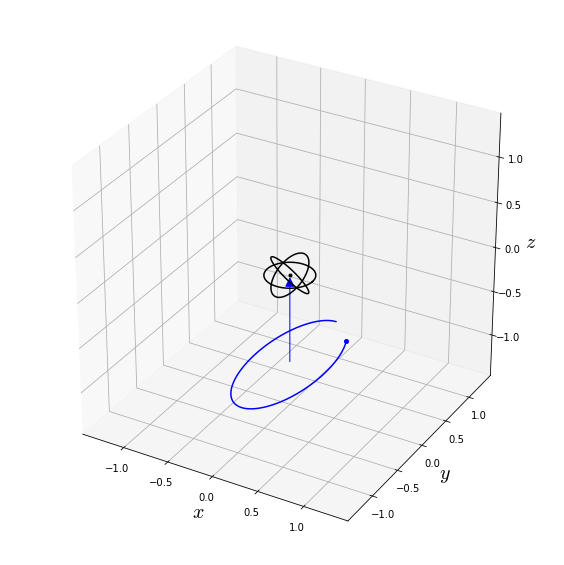

In [17]:
fig = plt.figure(figsize=(10, 10)); ax = fig.gca(projection='3d')
draw_lasers_3d(ax,[le], '_lasers.png')

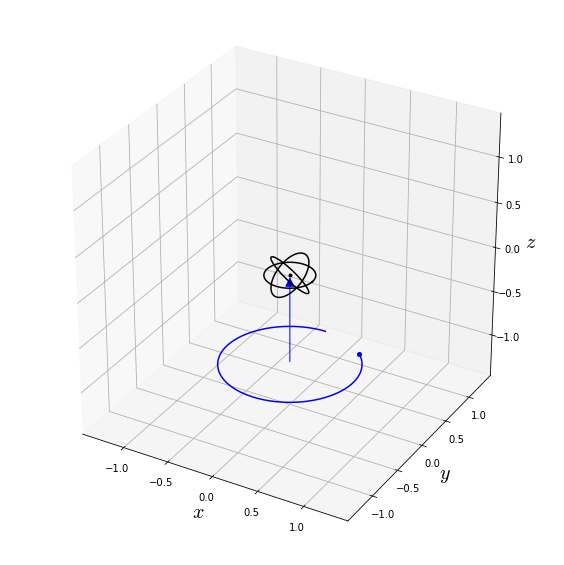

In [18]:
fig = plt.figure(figsize=(10, 10)); ax = fig.gca(projection='3d')
draw_lasers_3d(ax,[lp], '_lasers.png')

In [19]:
rho_resonant = rho[200]
intensity = radiated_intensity(rho_resonant, 1, 0, epsilonpz, rm, omega_level, xi, N, D, unfolding)
intensity

In [20]:
deltas, rho = sweep_steady_state(Ep, [epp], [[delta0, deltaf, Ndelta]])
rho_resonant = rho[200]

In [21]:
intensity = radiated_intensity(rho_resonant, 1, 0, epsilonpx, rm, omega_level, xi, N, D, unfolding)
intensity

In [22]:
deltas, rho = sweep_steady_state(Ep, [epl], [[delta0, deltaf, Ndelta]])
rho_resonant = rho[200]

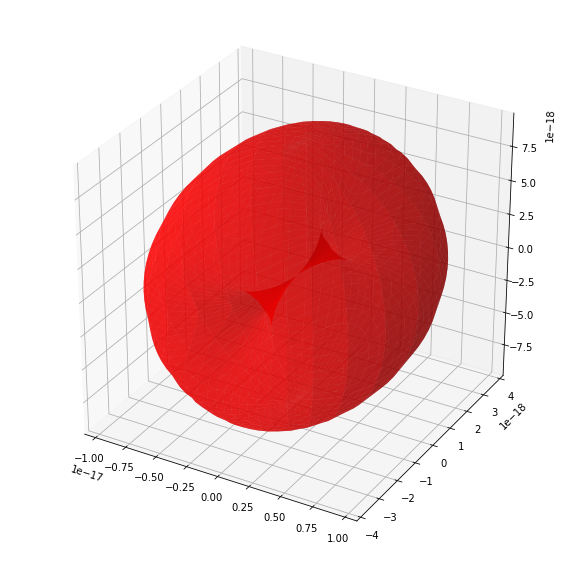

In [23]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Make data
Nphi = 39
Ntheta = 41
err = 0.001
phi = np.linspace(0, 2.0*np.pi, Nphi)
theta = np.linspace(0+err, 1.0*np.pi-err, Ntheta)

Ix = np.zeros((Nphi, Ntheta))
Iy = np.zeros((Nphi, Ntheta))
Iz = np.zeros((Nphi, Ntheta))

for i, phii in enumerate(phi):
    for j, thetaj in enumerate(theta):
        epV = polarization_vector(phii, thetaj, 0, 0, 1, numeric=True)
        epH = polarization_vector(phii, thetaj, np.pi/4, 0, 1, numeric=True)
        IV = radiated_intensity(rho_resonant, 1, 0, epV, rm, omega_level, xi, N, D, unfolding)
        IH = radiated_intensity(rho_resonant, 1, 0, epH, rm, omega_level, xi, N, D, unfolding)
        intensity = float(IV) + float(IH)
        Ix[i, j] = intensity*np.cos(phii)*np.sin(thetaj)
        Iy[i, j] = intensity*np.sin(phii)*np.sin(thetaj)
        Iz[i, j] = intensity*np.cos(thetaj)

ax.plot_surface(Ix, Iy, Iz, color='r', alpha=0.65)

In [24]:
deltas, rho = sweep_steady_state(Ep, [epe], [[delta0, deltaf, Ndelta]])
rho_resonant = rho[200]

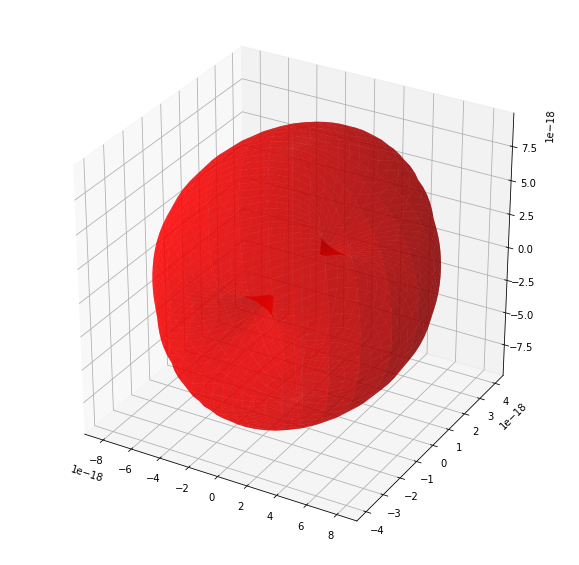

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Make data
Nphi = 39
Ntheta = 41
err = 0.001
phi = np.linspace(0, 2.0*np.pi, Nphi)
theta = np.linspace(0+err, 1.0*np.pi-err, Ntheta)

Ix = np.zeros((Nphi, Ntheta))
Iy = np.zeros((Nphi, Ntheta))
Iz = np.zeros((Nphi, Ntheta))

for i, phii in enumerate(phi):
    for j, thetaj in enumerate(theta):
        epV = polarization_vector(phii, thetaj, 0, 0, 1, numeric=True)
        epH = polarization_vector(phii, thetaj, np.pi/4, 0, 1, numeric=True)
        IV = radiated_intensity(rho_resonant, 1, 0, epV, rm, omega_level, xi, N, D, unfolding)
        IH = radiated_intensity(rho_resonant, 1, 0, epH, rm, omega_level, xi, N, D, unfolding)
        intensity = float(IV) + float(IH)
        Ix[i, j] = intensity*np.cos(phii)*np.sin(thetaj)
        Iy[i, j] = intensity*np.sin(phii)*np.sin(thetaj)
        Iz[i, j] = intensity*np.cos(thetaj)

ax.plot_surface(Ix, Iy, Iz, color='r', alpha=0.65)

In [26]:
deltas, rho = sweep_steady_state(Ep, [epp], [[delta0, deltaf, Ndelta]])
rho_resonant = rho[200]

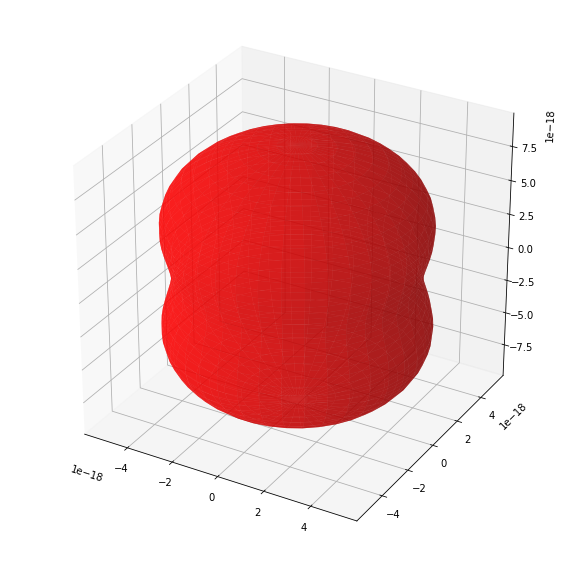

In [27]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Make data
Nphi = 39
Ntheta = 41
err = 0.001
phi = np.linspace(0, 2.0*np.pi, Nphi)
theta = np.linspace(0+err, 1.0*np.pi-err, Ntheta)

Ix = np.zeros((Nphi, Ntheta))
Iy = np.zeros((Nphi, Ntheta))
Iz = np.zeros((Nphi, Ntheta))

for i, phii in enumerate(phi):
    for j, thetaj in enumerate(theta):
        epV = polarization_vector(phii, thetaj, 0, 0, 1, numeric=True)
        epH = polarization_vector(phii, thetaj, np.pi/4, 0, 1, numeric=True)
        IV = radiated_intensity(rho_resonant, 1, 0, epV, rm, omega_level, xi, N, D, unfolding)
        IH = radiated_intensity(rho_resonant, 1, 0, epH, rm, omega_level, xi, N, D, unfolding)
        intensity = float(IV) + float(IH)
        Ix[i, j] = intensity*np.cos(phii)*np.sin(thetaj)
        Iy[i, j] = intensity*np.sin(phii)*np.sin(thetaj)
        Iz[i, j] = intensity*np.cos(thetaj)

ax.plot_surface(Ix, Iy, Iz, color='r', alpha=0.65)